In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import mdtraj as md
import matplotlib as mpl
#from nglview.player import TrajectoryPlayer
import os
from Bio import pairwise2
import pandas
import itertools
from matplotlib import rc
from matplotlib import rcParams


In [2]:
# You can edit these at some point if you want to change the formatting of your figures
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Key Information from Andrew:
CD1d
resname: CQSTGAHWVFWLIFYSFDVLLLVAFVFILWWVALDWTTVLLTCFL

resid: 12, 14, 16, 26, 28, 30, 38, 40, 47, 58, 63, 66, 69, 70, 73, 76, 77, 80, 81, 88, 90, 96, 98, 100, 114, 116, 118, 123, 124, 131, 140, 141, 144, 148, 151, 153, 154, 157, 158, 161, 162, 165, 166, 169, 173

segname: PROA

UFA
resname: LYFMGLEYEQALIILVLVWCVLVVCLVCGVSLIMIILFILLRCNVG

resid: 10, 12, 14, 28, 30, 32, 38, 62, 65, 66, 69, 73, 77, 81, 84, 85, 88, 95, 97, 99, 111, 113, 115, 121, 123, 125, 128, 130, 132, 135, 137, 139, 140, 142, 143, 146, 147, 153, 154, 156, 157, 160, 161, 164, 168, 172

segname: PROA

In [4]:
topfile = 'cd1d_apo_37_1/step3_input.pdb'
struct = md.load_pdb(topfile)
table,bonds = struct.topology.to_dataframe()
# Use this to print out what we're actually looking at
struct.topology

<mdtraj.Topology with 4 chains, 28071 residues, 88651 atoms, 61037 bonds at 0x7f93290e6090>

In [5]:
cd1_resids = '12 14 16 26 28 30 38 40 47 58 63 66 69 70 73 76 77 80 81 88 90 96 98 100 114 116 118 123 124 131 140 141 144 148 151 153 154 157 158 161 162 165 166 169 173'
cd1_resname = 'CQSTGAHWVFWLIFYSFDVLLLVAFVFILWWVALDWTTVLLTCFL'
ufa_resids = '10 12 14 28 30 32 38 62 65 66 69 73 77 81 84 85 88 95 97 99 111 113 115 121 123 125 128 130 132 135 137 139 140 142 143 146 147 153 154 156 157 160 161 164 168 172'
ufa_resname = 'LYFMGLEYEQALIILVLVWCVLVVCLVCGVSLIMIILFILLRCNVG'

In [6]:
mdsel_full = struct.topology.select("chainid == 0 and resid 1 to 180 and name CA ")
mdsel = struct.topology.select("chainid == 0 and sidechain and not name H and residue "+cd1_resids)

In [ ]:
# This is how I deal with memory issues
# I had explicitly defined the names of the trajectory files
# in the "trajfile" instance. In this system, I can probably just 
# do for i in np.arange(30) load dyn+str(i)
frames=200
first_frame = md.load_frame(topfile,0)
rmsdpre = []
rmsdFullpre = []
max_dyn = 1
pocket_pairs = list(itertools.product(mdsel, mdsel))
sasa_pre=[]
for dyn in np.arange(max_dyn):
    chunk=md.load('cd1d_apo_37_1/dyn'+str(dyn+1)+'.dcd',top=topfile)
    rmsdpre.append(md.rmsd(chunk, first_frame,atom_indices=mdsel))
    rmsdFullpre.append(md.rmsd(chunk, first_frame,atom_indices=mdsel_full))
    
    pocket_dists = md.compute_distances(chunk, atom_pairs=pocket_pairs, periodic=False)
    
    sasa_pre.append(md.shrake_rupley(chunk,mode='residue'))
    
cryst_dists = md.compute_distances(first_frame, atom_pairs=pocket_pairs, periodic=False)
rmsd=np.reshape(rmsdpre,(max_dyn)*frames)
rmsdFull=np.reshape(rmsdFullpre,(max_dyn)*frames)
sasa= np.reshape(sasa_pre,(max_dyn)*frames)

In [ ]:
pl.plot(sasa)

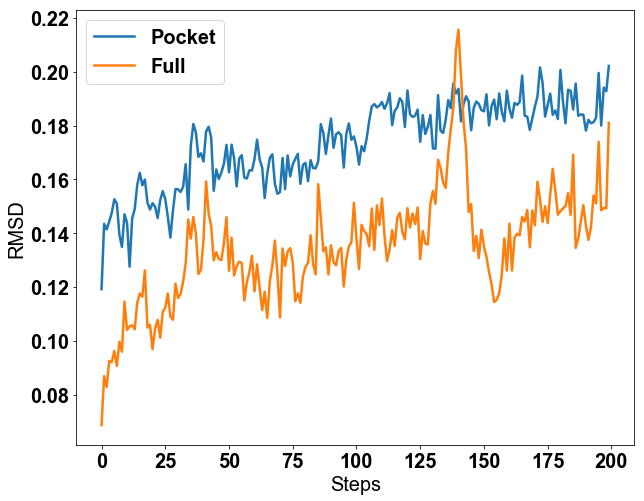

In [8]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
pl.plot(rmsd,linewidth=2.5)
pl.plot(rmsdFull,linewidth=2.5)
pl.xlabel('Steps')
pl.ylabel('RMSD')
pl.legend(['Pocket','Full'])

In [9]:
first = True
for atom_index in np.arange(len(mdsel)):
    atom1 = mdsel[atom_index]
    atom_ID1 = table[table['serial'] == atom1][['resName','resSeq','name']].values[0]
    if first:
        atom_df = np.transpose(pandas.DataFrame(atom_ID1))
        first = False
    else:
        atom_df = pandas.concat([atom_df,np.transpose(pandas.DataFrame(atom_ID1))])

In [10]:
atom_id_iter = pandas.DataFrame(itertools.product(atom_df.values,atom_df.values))

In [12]:
dist_ref_df = pandas.concat([atom_id_iter,pandas.DataFrame(np.arange(len(atom_id_iter)))],axis=1)
dist_ref_df.columns = ['Pair1','Pair2','Loc']
save_pair = []
first = True
for i in np.arange(len(dist_ref_df)):
    pair1 = dist_ref_df.loc[i]['Pair1'][1]
    pair2 = dist_ref_df.loc[i]['Pair2'][1]
    if pair1 == pair2:
        # Because of the nature of the setup here,
        # this will always be true the first go-around
        pair_prev1 = pair1
        pair_prev2 = pair2
        continue
    
    if first:
        loc_list = [dist_ref_df.loc[i]['Loc']]
        first = False
        pair_prev1 = pair1
        pair_prev2 = pair2
        continue
        
    if pair1 == pair_prev1 and pair2 == pair_prev2:
        loc_list = loc_list + [dist_ref_df.loc[i]['Loc']]
    else:
        if len(save_pair) == 0:
            save_pair = np.transpose(pandas.DataFrame([pair_prev1,pair_prev2,loc_list]))
        else:
            save_pair = pandas.concat([save_pair,np.transpose(pandas.DataFrame([pair_prev1,pair_prev2,loc_list]))])
        pair_prev1 = pair1
        pair_prev2 = pair2
        loc_list = [dist_ref_df.loc[i]['Loc']]

# Alright let's pull out some very specific pairs from the CD1d structure
Ser76-Trp153 // Tyr73-Thr154 // Phe70-Leu161 // Ile69-Leu161
# Now Try to find a few from UFA Structure:


In [340]:
pain = x[1:-1]+','
pain2 = pain.split()
fin = [int(a[:-1]) for a in pain2]
pocket_dists[:,fin]

array([[1.296385  , 1.1057596 , 1.0081363 , ..., 1.1112776 , 0.892053  ,
        0.877542  ],
       [1.0916934 , 0.88281244, 0.806308  , ..., 0.8232082 , 0.69059014,
        0.70570284],
       [1.0557611 , 0.8708279 , 0.7847237 , ..., 0.83619577, 0.6823072 ,
        0.6903458 ],
       ...,
       [1.1223865 , 0.93177265, 0.8357185 , ..., 0.8731917 , 0.7247708 ,
        0.7219805 ],
       [1.1058631 , 0.93094605, 0.8475559 , ..., 0.8426223 , 0.6806319 ,
        0.68073565],
       [1.0756332 , 0.88699347, 0.8124684 , ..., 0.753375  , 0.60866916,
        0.58739823]], dtype=float32)

In [11]:
key_cd1_pairs = [[76,153],[73,154],[70,161],[69,161]]
final_distance_df = []
for i in np.arange(len(key_cd1_pairs)):
    pre1 = save_pair[save_pair['Resid1'] == key_cd1_pairs[i][0]]
    pre2 = pre1[pre1['Resid2'] == key_cd1_pairs[i][1]]
    fin_location = pre2['Dist_loc']
    first = True
    for x in fin_location.values:
        # Have to do some crazy processing when loading back in the saved dataframe:
        pain = x[1:-1]+','
        pain2 = pain.split()
        fin = [int(a[:-1]) for a in pain2]
        pocket_sub = pocket_dists[:,fin]
        cryst_sub = cryst_dists[:,fin]
        if first:
            pocket_f = pocket_sub
            cryst_f = cryst_sub
            first = False
        else:
            pocket_f = np.hstack((pocket_f,pocket_sub))
            cryst_f = np.hstack((cryst_f,cryst_sub))
            
    fin_dist = [key_cd1_pairs[i][0],key_cd1_pairs[i][1],np.average(cryst_f),np.average(pocket_f,axis=1)]
    if len(final_distance_df) == 0:
        final_distance_df = np.transpose(pandas.DataFrame(fin_dist))
    else:
        final_distance_df = pandas.concat([final_distance_df, np.transpose(pandas.DataFrame(fin_dist))])


key_cd1_pairs = [[76,153],[73,154],[70,161],[69,161]]
Ser76-Trp153 // Tyr73-Thr154 // Phe70-Leu161 // Ile69-Leu161

In [8]:
# The temperatures can either be 27 or 37
temp=27

if temp ==27:
    cd1_sasa1 = pandas.read_csv('datfiles/cdd271.dat',header=None)
    cd1_sasa2 = pandas.read_csv('datfiles/cdd272.dat',header=None)
    cd1_sasa3 = pandas.read_csv('datfiles/cdd273.dat',header=None)
    ufa_sasa1 = pandas.read_csv('datfiles/ufa271.dat',header=None)
    ufa_sasa2 = pandas.read_csv('datfiles/ufa272.dat',header=None)
    ufa_sasa3 = pandas.read_csv('datfiles/ufa273.dat',header=None)

if temp==37:
    cd1_sasa1 = pandas.read_csv('datfiles/cdd371.dat',header=None)
    cd1_sasa2 = pandas.read_csv('datfiles/cdd372.dat',header=None)
    cd1_sasa3 = pandas.read_csv('datfiles/cdd373.dat',header=None)
    ufa_sasa1 = pandas.read_csv('datfiles/ufa371.dat',header=None)
    ufa_sasa2 = pandas.read_csv('datfiles/ufa372.dat',header=None)
    ufa_sasa3 = pandas.read_csv('datfiles/ufa373.dat',header=None)

In [78]:
sasa = ufa_sasa3
i = sasa.idxmax().values[0]
print(sasa.max())
print('Frame: '+str(i%200)+', Dyn: '+str(np.ceil(i/200.0)))

0    1322.333252
dtype: float64
Frame: 57, Dyn: 10.0


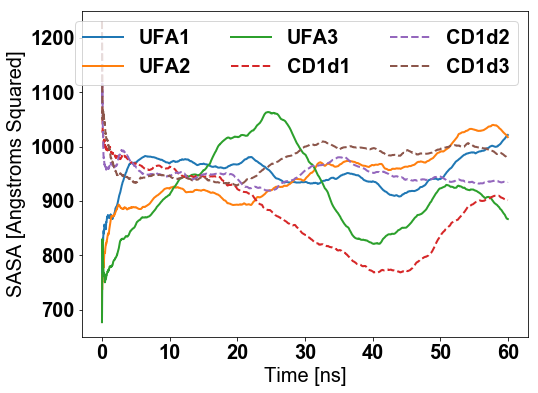

In [22]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(8,6))
#pl.plot(cd1_sasa)
#pl.plot(ufa_sasa1)
#pl.plot(ufa_sasa2)
#pl.plot(ufa_sasa3)

# Running average of trajectories
# Alter the window size of your running average
win=1000
a = 1
for sasa in [ufa_sasa1.values,ufa_sasa2.values,ufa_sasa3.values]:
    zz1=np.zeros(len(sasa))
    for i in range(len(sasa)):
        if i < win:
            zz1[i]=sum(sasa[:(i+1)])/(i+1)
        else:
            zz1[i]=sum(sasa[(i-win):(i+1)])/win
    xaxis = np.arange(0,60,60.0/len(zz1))
    pl.plot(xaxis,zz1,linewidth=2)
    
    # Alright now we need to save these as a csv.
    #zz_df=pandas.DataFrame(zz1)
    #zz_df.to_csv('ufa_'+str(temp)+'C_rep'+str(a)+'.csv',index=False,header=False)
    #a=a+1
    
a=1
for sasa in [cd1_sasa1.values,cd1_sasa2.values,cd1_sasa3.values]:
    zz1=np.zeros(len(sasa))
    for i in range(len(sasa)):
        if i < win:
            zz1[i]=sum(sasa[:(i+1)])/(i+1)
        else:
            zz1[i]=sum(sasa[(i-win):(i+1)])/win
    xaxis = np.arange(0,60,60.0/len(zz1))
    pl.plot(xaxis,zz1,linewidth=2,linestyle='dashed')
    
    #zz_df=pandas.DataFrame(zz1)
    #zz_df.to_csv('cd1_'+str(temp)+'C_rep'+str(a)+'.csv',index=False,header=False)
    #a=a+1

pl.ylim([650,1250])
pl.xlabel('Time [ns]')
pl.ylabel('SASA [Angstroms Squared]')
pl.legend(['UFA1','UFA2','UFA3','CD1d1','CD1d2','CD1d3'],ncol=3)
#pl.savefig('sasa_avg_'+str(temp)+'.pdf',format='pdf')

In [21]:
test_sasa = cd1_sasa
print('Maximum Platform SASA: '+str(np.max(test_sasa).values[0]))
print('Average Platform SASA: '+str(np.average(test_sasa)))

for i in np.arange(len(test_sasa)):
    if test_sasa.values[i][0] >= (np.average(test_sasa)+3*np.std(test_sasa)).values[0]:
        print('Frame: '+str(i%200)+', Dyn: '+str(np.ceil(i/200.0))+', SASA_pocket: '+str(test_sasa.values[i][0]))

Maximum Platform SASA: 1245.9122314453125
Average Platform SASA: 870.7401150304702
Frame: 0, Dyn: 0.0, SASA_pocket: 1229.8138427734375
Frame: 1, Dyn: 1.0, SASA_pocket: 1160.197265625
Frame: 29, Dyn: 1.0, SASA_pocket: 1214.2283935546875
Frame: 164, Dyn: 1.0, SASA_pocket: 1157.0621337890625
Frame: 14, Dyn: 2.0, SASA_pocket: 1158.178466796875
Frame: 157, Dyn: 4.0, SASA_pocket: 1181.008056640625
Frame: 168, Dyn: 4.0, SASA_pocket: 1187.90869140625
Frame: 170, Dyn: 4.0, SASA_pocket: 1177.1373291015625
Frame: 171, Dyn: 4.0, SASA_pocket: 1245.9122314453125
Frame: 192, Dyn: 5.0, SASA_pocket: 1166.4359130859375
Frame: 193, Dyn: 5.0, SASA_pocket: 1191.6556396484375
Frame: 172, Dyn: 7.0, SASA_pocket: 1157.8870849609375
Frame: 173, Dyn: 7.0, SASA_pocket: 1189.8846435546875
Frame: 174, Dyn: 7.0, SASA_pocket: 1228.806884765625
Frame: 175, Dyn: 7.0, SASA_pocket: 1173.13525390625


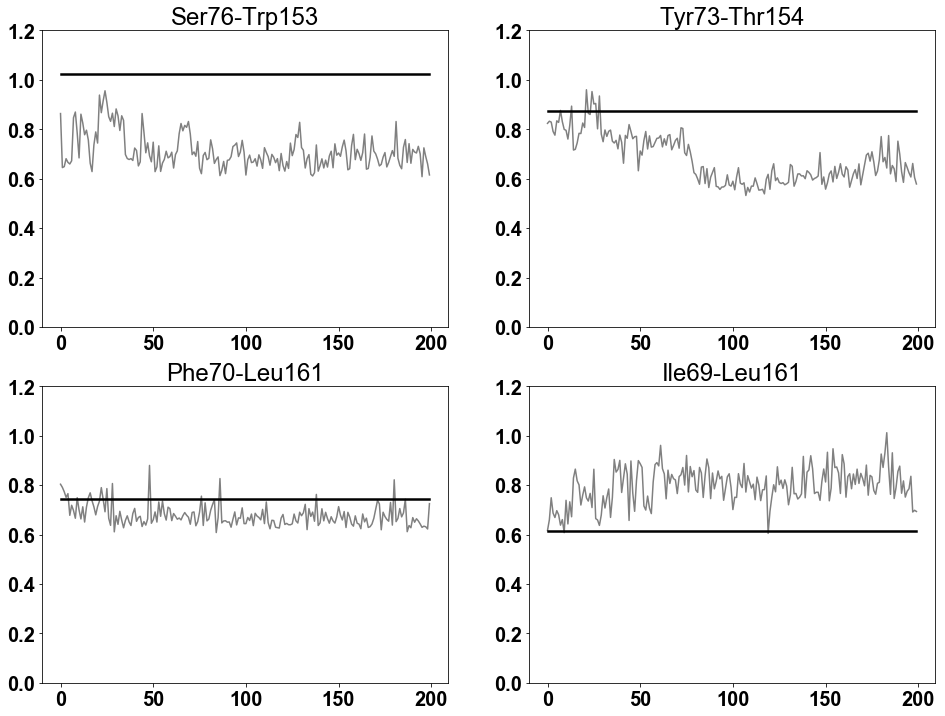

In [13]:
fig, ax = pl.subplots(2, 2,squeeze=False,figsize=(16,12))
ax[0,0].plot(final_distance_df.values[0][3],color='Gray')
ax[0,0].set_title('Ser76-Trp153'); ax[0,0].set_ylim([0,1.2])
ax[0,1].plot(final_distance_df.values[1][3],color='Gray')
ax[0,1].set_title('Tyr73-Thr154'); ax[0,1].set_ylim([0,1.2])
ax[1,0].plot(final_distance_df.values[2][3],color='Gray')
ax[1,0].set_title('Phe70-Leu161'); ax[1,0].set_ylim([0,1.2])
ax[1,1].plot(final_distance_df.values[3][3],color='Gray')
ax[1,1].set_title('Ile69-Leu161'); ax[1,1].set_ylim([0,1.2])
traj_len = len(final_distance_df.values[0][3])
ax[0,0].plot(np.arange(traj_len),np.ones(traj_len)*final_distance_df.values[0][2],color='black',linewidth=2.5)
ax[0,1].plot(np.arange(traj_len),np.ones(traj_len)*final_distance_df.values[1][2],color='black',linewidth=2.5)
ax[1,0].plot(np.arange(traj_len),np.ones(traj_len)*final_distance_df.values[2][2],color='black',linewidth=2.5)
ax[1,1].plot(np.arange(traj_len),np.ones(traj_len)*final_distance_df.values[3][2],color='black',linewidth=2.5)


In [35]:
dist_test = final_distance_df.values[0][3]
ser_trp_dist = final_distance_df.values[0][2]
print('Minimum Platform RMSD: '+str(np.min(rmsd)))
print('Minimum Full RMSD: '+str(np.min(rmsdFull)))
print('Average Platform RMSD: '+str(np.average(rmsd)))
print('Average Full RMSD: '+str(np.average(rmsdFull)))
for i in np.arange(len(dist_test)):
    if dist_test[i] >= ser_trp_dist:
        print('Frame: '+str(i%200)+', Dyn: '+str(np.ceil(i/200.0))+', RMSD_pocket: '+str(rmsd[i])+', RMSD_full: '+str(rmsdFull[i]) )

Minimum Platform RMSD: 0.11926696
Minimum Full RMSD: 0.068766765
Average Platform RMSD: 0.17347378
Average Full RMSD: 0.13472185


In [45]:
def convert_3Let(inp):
    first = True
    three_let = ['ALA','GLY','ARG','LYS','ASP','GLU','ASN','GLN','MET','CYS','PHE','TYR','THR','TRP','PRO','SER','LEU','VAL','HIS','ILE']
    sin_let = [  'A',  'G',  'R',  'K',  'D',  'E',  'N',  'Q',  'M',  'C',  'F',  'Y',  'T',  'W',  'P',  'S',  'L',  'V',  'H',  'I']
    sin_final = []
    for i in inp:
        hold = []
        for scan in np.arange(len(three_let)):
            if i.lower() == three_let[scan].lower():
                hold = sin_let[scan]
                break
        # In these pdbs especially, there will occasionally be some
        # weird residues (artifical AAs or otherwise)
        if len(hold) == 0:
            continue
        if first:
            sin_final = hold
            first = False
        else:
            sin_final = np.hstack((sin_final,hold))
    if len(sin_final) == 0:
        return()
    return(sin_final)


In [94]:
first = True
for atom_index in mdsel:
    atom_ID = table[table['serial'] == atom_index][['resName','resSeq','name']].values[0]
    atom_df = np.transpose(pandas.DataFrame(atom_ID))
    if first:
        atom_cat = atom_df
        first = False
    else:
        atom_cat = pandas.concat([atom_cat,atom_df],axis=0)
        
seq_check = ''.join(convert_3Let(atom_cat.drop_duplicates(1)[0].values))
cd1_resname == seq_check

True